In [1]:
# Essentials
import os, sys, glob
import pandas as pd
import numpy as np
import nibabel as nib
import scipy.io as sio

# Stats
import scipy as sp
from scipy import stats
import statsmodels.api as sm
import pingouin as pg

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
sys.path.append('/Users/lindenmp/Google-Drive-Penn/work/research_projects/normative_neurodev_cs_t1/1_code/')
from func import set_proj_env, my_get_cmap, get_fdr_p

In [3]:
train_test_str = 'train_test'
exclude_str = 't1Exclude' # 't1Exclude' 'fsFinalExclude'
parc_str = 'schaefer' # 'schaefer' 'lausanne'
parc_scale = 400 # 200 400 | 60 125 250
parcel_names, parcel_loc, drop_parcels, num_parcels, yeo_idx, yeo_labels = set_proj_env(exclude_str = exclude_str, parc_str = parc_str, parc_scale = parc_scale)

In [4]:
# output file prefix
outfile_prefix = exclude_str+'_'+parc_str+'_'+str(parc_scale)+'_'
outfile_prefix

't1Exclude_schaefer_400_'

### Setup directory variables

In [5]:
figdir = os.path.join(os.environ['OUTPUTDIR'], 'figs')
print(figdir)
if not os.path.exists(figdir): os.makedirs(figdir)

/Users/lindenmp/Google-Drive-Penn/work/research_projects/normative_neurodev_cs_t1/3_output/figs


In [6]:
labels = ['Train', 'Test']
phenos = ['Overall_Psychopathology','Psychosis_Positive','Psychosis_NegativeDisorg','AnxiousMisery','Externalizing','Fear']
phenos_label_short = ['Ov. Psych.', 'Psy. (pos.)', 'Psy. (neg.)', 'Anx.-mis.', 'Ext.', 'Fear']
phenos_label = ['Overall Psychopathology','Psychosis (positive)','Psychosis (negative)','Anxious-misery','Externalizing','Fear']

## Setup plots

In [7]:
if not os.path.exists(figdir): os.makedirs(figdir)
os.chdir(figdir)
sns.set(style='white', context = 'paper', font_scale = 0.8)
cmap = my_get_cmap('pair')

## Load data

In [8]:
df = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '1_compute_node_features', 'out', outfile_prefix+'df.csv'))
df.set_index(['bblid', 'scanid'], inplace = True)
print(df.shape)

(1376, 48)


In [9]:
df['ageAtScan1_Years'].mean()

14.975290697674419

In [10]:
df['ageAtScan1_Years'].std()

3.638227328968269

In [11]:
df['sex'].unique()

array([1, 2])

In [12]:
print(np.sum(df.loc[:,'sex'] == 1))
print(np.round((np.sum(df.loc[:,'sex'] == 1)/df.shape[0]) * 100,2))

654
47.53


In [13]:
print(np.sum(df.loc[:,'sex'] == 2))
print(np.round((np.sum(df.loc[:,'sex'] == 2)/df.shape[0]) * 100,2))

722
52.47


In [14]:
np.sum(df.loc[:,'averageManualRating'] == 2)

1139

In [15]:
for pheno in phenos:
    print(sp.stats.spearmanr(df.loc[:,'averageManualRating'],df.loc[:,pheno]))

SpearmanrResult(correlation=0.044831903932345776, pvalue=0.09644455101775931)
SpearmanrResult(correlation=-0.054836323328827645, pvalue=0.04197112938052458)
SpearmanrResult(correlation=-0.04143078607961845, pvalue=0.12450991600442735)
SpearmanrResult(correlation=0.054701579459443046, pvalue=0.04247853070713916)
SpearmanrResult(correlation=-0.0488443388701072, pvalue=0.07009603884658773)
SpearmanrResult(correlation=0.015387256948274253, pvalue=0.5684761184910897)


In [16]:
# train/test proportion
print('train N:', np.sum(df.loc[:,train_test_str] == 0))
print(np.round(df.loc[df.loc[:,train_test_str] == 0,'ageAtScan1_Years'].mean(),2))
print(np.round(df.loc[df.loc[:,train_test_str] == 0,'ageAtScan1_Years'].std(),2))

train N: 308
14.36
3.92


In [17]:
print('test N:', np.sum(df.loc[:,train_test_str] == 1))
print(np.round(df.loc[df.loc[:,train_test_str] == 1,'ageAtScan1_Years'].mean(),2))
print(np.round(df.loc[df.loc[:,train_test_str] == 1,'ageAtScan1_Years'].std(),2))

test N: 1068
15.15
3.53


0 = Male, 1 = Female

In [18]:
# train/test proportion
print('train, sex = 1, N:', np.sum(df.loc[df.loc[:,train_test_str] == 0,'sex'] == 1))
print(np.round((np.sum(df.loc[df.loc[:,train_test_str] == 0,'sex'] == 1)/np.sum(df.loc[:,train_test_str] == 0)) * 100,2))
print('train, sex = 2, N:',np.sum(df.loc[df.loc[:,train_test_str] == 0,'sex'] == 2))
print(np.round((np.sum(df.loc[df.loc[:,train_test_str] == 0,'sex'] == 2)/np.sum(df.loc[:,train_test_str] == 0)) * 100,2))

print('test, sex = 1, N:', np.sum(df.loc[df.loc[:,train_test_str] == 1,'sex'] == 1))
print(np.round((np.sum(df.loc[df.loc[:,train_test_str] == 1,'sex'] == 1)/np.sum(df.loc[:,train_test_str] == 1)) * 100,2))
print('test, sex = 2, N:',np.sum(df.loc[df.loc[:,train_test_str] == 1,'sex'] == 2))
print(np.round((np.sum(df.loc[df.loc[:,train_test_str] == 1,'sex'] == 2)/np.sum(df.loc[:,train_test_str] == 1)) * 100,2))

train, sex = 1, N: 153
49.68
train, sex = 2, N: 155
50.32
test, sex = 1, N: 501
46.91
test, sex = 2, N: 567
53.09


### Sex

In [19]:
stats = pd.DataFrame(index = phenos, columns = ['test_stat', 'pval'])

for i, pheno in enumerate(phenos):
    x = df.loc[df.loc[:,'sex'] == 1,pheno]
#     x = df.loc[np.logical_and(df[train_test_str] == 1,df['sex'] == 1),pheno]
    y = df.loc[df.loc[:,'sex'] == 2,pheno]
#     y = df.loc[np.logical_and(df[train_test_str] == 1,df['sex'] == 2),pheno]
    
    test_output = sp.stats.ttest_ind(x,y)
    stats.loc[pheno,'test_stat'] = test_output[0]
    stats.loc[pheno,'pval'] = test_output[1]
    
stats.loc[:,'pval_corr'] = get_fdr_p(stats.loc[:,'pval'])
stats.loc[:,'sig'] = stats.loc[:,'pval_corr'] < 0.05

np.round(stats.astype(float),2)

,test_stat,pval,pval_corr,sig
Overall_Psychopathology,-1.50,0.13,0.13,0.0
Psychosis_Positive,2.05,0.04,0.05,1.0
Psychosis_NegativeDisorg,4.23,0.00,0.00,1.0
AnxiousMisery,-4.57,0.00,0.00,1.0
Externalizing,5.44,0.00,0.00,1.0
Fear,-6.25,0.00,0.00,1.0


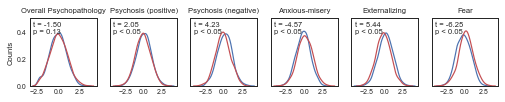

In [20]:
sns.set(style='white', context = 'paper', font_scale = 0.8)
f, ax = plt.subplots(1,len(phenos))
f.set_figwidth(len(phenos)*1.4)
f.set_figheight(1.25)

# sex: 1=male, 2=female
for i, pheno in enumerate(phenos):
    x = df.loc[df.loc[:,'sex'] == 1,pheno]
#     x = df.loc[np.logical_and(df[train_test_str] == 1,df['sex'] == 1),pheno]
    sns.kdeplot(x, ax = ax[i], label = 'male', color = 'b')

    y = df.loc[df.loc[:,'sex'] == 2,pheno]
#     y = df.loc[np.logical_and(df[train_test_str] == 1,df['sex'] == 2),pheno]
    sns.kdeplot(y, ax = ax[i], label = 'female', color = 'r')
    
    ax[i].set_xlabel('')
    ax[i].set_title(phenos_label[i])
#     if stats.loc[pheno,'sig']:
#         ax[i].set_title('t-stat:' + str(np.round(stats.loc[pheno,'test_stat'],2)) + ', p-value: ' + str(np.round(stats.loc[pheno,'pval_corr'],4)), fontweight="bold")
#     else:
#         ax[i].set_title('t-stat:' + str(np.round(stats.loc[pheno,'test_stat'],2)) + ', p-value: ' + str(np.round(stats.loc[pheno,'pval_corr'],4)))
    ax[i].tick_params(pad = -2)
    ax[i].set_ylim([0,0.5])
    if i == 0:
        ax[i].set_ylabel('Counts')
    else:
        ax[i].set_ylabel('')
        
    if i != 0:
        ax[i].set_yticklabels('')
#     if i == 0:
#         ax[i].legend()

    if stats.loc[pheno,'sig']:
        textstr = 't = {:.2f} \np < 0.05'.format(stats.loc[pheno,'test_stat'])
    else:
        textstr = 't = {:.2f} \np = {:.2f}'.format(stats.loc[pheno,'test_stat'], stats.loc[pheno,'pval_corr'])
    ax[i].text(0.05, 0.95, textstr, transform=ax[i].transAxes,
            verticalalignment='top')
        
f.savefig(outfile_prefix+'symptoms_distributions_sex.svg', dpi = 300, bbox_inches = 'tight', pad_inches = 0)

### nuisance correlations

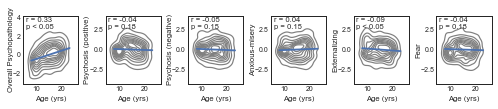

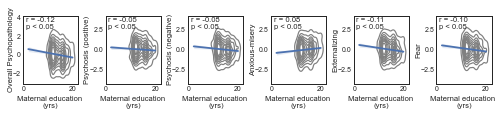

In [21]:
sns.set(style='white', context = 'paper', font_scale = 0.8)
stats = pd.DataFrame(index = phenos, columns = ['r', 'pval'])
# covs = ['ageAtScan1_Years', 'mprage_antsCT_vol_TBV', 'medu1', 'averageManualRating']
covs = ['ageAtScan1_Years', 'medu1']
# covs_label = ['Age',]
covs_label = ['Age (yrs)', 'Maternal education \n(yrs)']
for c, cov in enumerate(covs):
    x = df[cov]
    for i, pheno in enumerate(phenos):
        y = df[pheno]
        r,p = sp.stats.pearsonr(x,y)

        stats.loc[pheno,'r'] = r
        stats.loc[pheno,'pval'] = p

    stats.loc[:,'pval_corr'] = get_fdr_p(stats.loc[:,'pval'])
    stats.loc[:,'sig'] = stats.loc[:,'pval_corr'] < 0.05

    f, ax = plt.subplots(1,len(phenos))
    f.set_figwidth(len(phenos)*1.4)
    f.set_figheight(1.25)

    x = df[cov]
    for i, pheno in enumerate(phenos):
        y = df[pheno]
        plot_data = pd.merge(x,y, on=['bblid','scanid'])
        sns.kdeplot(x = cov, y = pheno, data = plot_data, ax=ax[i], color='gray')
        sns.regplot(x = cov, y = pheno, data = plot_data, ax=ax[i], scatter=False)

        ax[i].set_ylabel(phenos_label[i], labelpad=-1)
        ax[i].set_xlabel(covs_label[c])
        ax[i].tick_params(pad = -2.5)
        
        if stats.loc[pheno,'sig']:
            textstr = 'r = {:.2f} \np < 0.05'.format(stats.loc[pheno,'r'])
        else:
            textstr = 'r = {:.2f} \np = {:.2f}'.format(stats.loc[pheno,'r'], stats.loc[pheno,'pval_corr'])

        ax[i].text(0.05, 0.975, textstr, transform=ax[i].transAxes,
                verticalalignment='top')

    f.subplots_adjust(wspace=0.5)
    f.savefig(outfile_prefix+'symptoms_correlations_'+cov+'.svg', dpi = 300, bbox_inches = 'tight', pad_inches = 0)

### Diagnostic table

In [22]:
df['goassessDxpmr4_bin'] = df.loc[:,'goassessDxpmr4'] == '4PS'
df['goassessDxpmr4_bin'] = df['goassessDxpmr4_bin'].astype(int)*4

In [23]:
to_screen = ['goassessDxpmr4_bin','goassessSmryMan', 'goassessSmryDep', 'goassessSmryBul', 'goassessSmryAno', 'goassessSmrySoc',
             'goassessSmryPan', 'goassessSmryAgr', 'goassessSmryOcd', 'goassessSmryPtd', 'goassessSmryAdd',
            'goassessSmryOdd', 'goassessSmryCon']
# counts = np.sum(df.loc[:,to_screen] == 4)
# counts = np.sum(df.loc[df.loc[:,train_test_str] == 0,to_screen] == 4)
counts = np.sum(df.loc[df.loc[:,train_test_str] == 1,to_screen] == 4)
print(counts)
print(np.round(counts/df.shape[0]*100,2))

goassessDxpmr4_bin    389
goassessSmryMan        14
goassessSmryDep       191
goassessSmryBul         5
goassessSmryAno        16
goassessSmrySoc       318
goassessSmryPan        14
goassessSmryAgr        77
goassessSmryOcd        43
goassessSmryPtd       168
goassessSmryAdd       226
goassessSmryOdd       448
goassessSmryCon       114
dtype: int64
goassessDxpmr4_bin    28.27
goassessSmryMan        1.02
goassessSmryDep       13.88
goassessSmryBul        0.36
goassessSmryAno        1.16
goassessSmrySoc       23.11
goassessSmryPan        1.02
goassessSmryAgr        5.60
goassessSmryOcd        3.12
goassessSmryPtd       12.21
goassessSmryAdd       16.42
goassessSmryOdd       32.56
goassessSmryCon        8.28
dtype: float64


In [24]:
to_keep = counts[counts >= 50].index
list(to_keep)

['goassessDxpmr4_bin',
 'goassessSmryDep',
 'goassessSmrySoc',
 'goassessSmryAgr',
 'goassessSmryPtd',
 'goassessSmryAdd',
 'goassessSmryOdd',
 'goassessSmryCon']

In [25]:
counts[counts >= 50]

goassessDxpmr4_bin    389
goassessSmryDep       191
goassessSmrySoc       318
goassessSmryAgr        77
goassessSmryPtd       168
goassessSmryAdd       226
goassessSmryOdd       448
goassessSmryCon       114
dtype: int64

In [26]:
my_xticklabels = ['Psychosis spectrum (n=389)',
                 'Depression (n=191)',
                 'Social anxiety disorder (n=318)',
                 'Agoraphobia (n=77)',
                 'PTSD (n=168)',
                 'ADHD (n=226)',
                 'ODD (n=448)',
                 'Conduct disorder (n=114)']

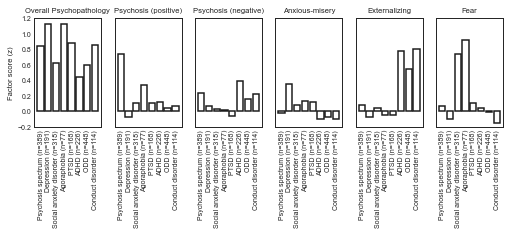

In [27]:
sns.set(style='white', context = 'paper', font_scale = 0.8)
f, ax = plt.subplots(1,len(phenos))
f.set_figwidth(len(phenos)*1.4)
f.set_figheight(2)

for i, pheno in enumerate(phenos):
    mean_scores = np.zeros(len(to_keep))
    for j, diagnostic_score in enumerate(to_keep):
        idx = df.loc[:,diagnostic_score] == 4
        mean_scores[j] = df.loc[idx,pheno].mean()
    
    ax[i].bar(x = np.arange(0,len(mean_scores)), height = mean_scores, color = 'w', edgecolor = 'k', linewidth = 1.5)
    ax[i].set_ylim([-.2,1.2])
    ax[i].set_xticks(np.arange(0,len(mean_scores)))
    ax[i].set_xticklabels(my_xticklabels, rotation = 90)
    ax[i].tick_params(pad = -2)
    ax[i].set_title(phenos_label[i])
#     if i == 1:
#         ax[i].set_xlabel('Diagnostic group')
    if i == 0:
        ax[i].set_ylabel('Factor score (z)')
    if i != 0:
        ax[i].set_yticklabels('')
    
f.savefig(outfile_prefix+'symptom_dimensions_groups.svg', dpi = 300, bbox_inches = 'tight', pad_inches = 0)